In [1]:
import sys
import os
import json
import torch
from collections import OrderedDict
from model import MolVAE
from textdata import textdata
from utils import idx2smiles, eval_prior_samples, smiles_to_mol, mol_weight, mol_qed, mol_sas, mol_logp, \
                    smiles2mean, latent2smiles, create_smiles_lst, perturb_z, to_cuda_var, \
                    pairwise_dist,upper_tri_indexing
from lorentz_model import *
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import rdBase
rdBase.DisableLog('rdApp.error') #disable RDKit warning messages
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
### Currently, this function only works for Euclidean space. Vector operations (e.g. sum, inner product) are different
### in Hyperbolic space
def perturb_z(z, noise_norm, constant_norm=False):
    if noise_norm > 0.0:
        noise_vec = np.random.normal(0, 1, size=z.shape)
        noise_vec = noise_vec / np.linalg.norm(noise_vec, axis=1).reshape(z.shape[0], 1)
        if constant_norm:
            return z + (noise_norm * noise_vec)
        else:
            noise_amp = np.random.uniform(0, noise_norm, size=(z.shape[0],1))
            return z + (noise_amp * noise_vec)
    else:
        return z

In [3]:
def dist_z(manifold_type, z1, z2):
    if manifold_type == 'Euclidean':
        d2 = torch.dist(z1, z2)
    elif manifold_type == 'Lorentz' :
        d2 = arccosh(-lorentz_product(z1,z2))
    return d2

In [4]:
def vae_pairwise_dist_hist(exp_name, num_mdls, input_smiles):
    dist_lst = []
    norm_lst = []
    for e in tqdm(range(num_mdls)):
        epoch = (e+1)*5
        exp_name = exp_name
        if epoch == 5:
            checkpoint = 'checkpoint_epoch005.model'
        else:
            checkpoint = 'checkpoint_epoch0'+str(epoch)+'.model'
            
        exp_dir = './experiments/SMILES/'
        config_path = os.path.join(exp_dir + exp_name, 'configs.json')
        checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)
        
        with open(config_path, 'r') as fp:
            configs = json.load(fp)
            fp.close()
            
        try:
            configs['prior_var']
        except:
            configs['prior_var'] = 1.0

        # prepare train, valid, test datasets
        datasets = OrderedDict()
        splits = ['train', 'valid', 'test']
        for split in splits:
            datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                                       max_sequence_length=configs['max_sequence_length'])

        #build model
        model = MolVAE(
            vocab_size=datasets['train'].vocab_size,
            embedding_size=datasets['train'].vocab_size,
            hidden_size=configs['hidden_size'],
            latent_size=configs['latent_size'],
            manifold_type=configs['manifold_type'],
            rnn_type=configs['rnn_type'],
            bidirectional=configs['bidirectional'],
            num_layers=configs['num_layers'],
            word_dropout_rate=configs['word_dropout_rate'],
            embedding_dropout_rate=configs['embedding_dropout_rate'],
            one_hot_rep=configs['one_hot_rep'],
            max_sequence_length=configs['max_sequence_length'],
            sos_idx=datasets['train'].sos_idx,
            eos_idx=datasets['train'].eos_idx,
            pad_idx=datasets['train'].pad_idx,
            unk_idx=datasets['train'].unk_idx,
            prior_var=configs['prior_var']
        )
        # load checkpoint
        model.load_state_dict(torch.load(checkpoint_path))
        if torch.cuda.is_available():
            model = model.cuda()
        model.eval()

        mu_lst = []
        for smi in input_smiles:
            try:
                mu, logv = smiles2mean(configs, smi, model)
                mu_lst.append(mu)
            except:
                pass

        mu_array = torch.stack(mu_lst).squeeze().cpu().detach().numpy()
        dist = pairwise_dist(configs['manifold_type'], mu_array)
        dist_lst.append(dist)
        
        if configs['manifold_type'] == 'Euclidean':
            norm_lst.append(np.linalg.norm(mu_array, ord=2, axis=1))
        elif configs['manifold_type'] == 'Lorentz':
            poincare_mu_array = lorentz_to_poincare(mu_array)
            norm_lst.append(np.linalg.norm(poincare_mu_array, ord=2, axis=1))
    return dist_lst, norm_lst

### Select a pre-trained model

In [5]:
exp_name = 'exp_a_8'
checkpoint = 'checkpoint_epoch020.model'

In [6]:
exp_dir = './experiments/SMILES/'
config_path = os.path.join(exp_dir + exp_name, 'configs.json')
checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

In [7]:
with open(config_path, 'r') as fp:
    configs = json.load(fp)
    fp.close()
try:
    configs['prior_var']
except:
    configs['prior_var'] = 1.0
configs

{'data_dir': './data',
 'data_file': '250k_rndm_zinc_drugs_clean.smi',
 'vocab_file': 'zinc_char_list.json',
 'checkpoint_dir': './experiments/SMILES',
 'experiment_name': 'exp_a_8',
 'limit': 249456,
 'batch_size': 128,
 'epochs': 60,
 'max_sequence_length': 120,
 'learning_rate': 0.0003,
 'max_norm': 1000000000000.0,
 'wd': 0.0,
 'manifold_type': 'Lorentz',
 'rnn_type': 'gru',
 'bidirectional': False,
 'num_layers': 1,
 'hidden_size': 500,
 'latent_size': 40,
 'one_hot_rep': True,
 'word_dropout_rate': 0.2,
 'embedding_dropout_rate': 0.0,
 'anneal_function': 'logistic',
 'k': 0.51,
 'x0': 29.0,
 'num_workers': 1,
 'logging_steps': 1,
 'save_per_epochs': 5,
 'new_training': True,
 'new_annealing': False,
 'checkpoint': 'checkpoint_epoch100.model',
 'trained_epochs': 100,
 'prior_var': 1.0}

In [8]:
# prepare train, valid, test datasets
datasets = OrderedDict()
splits = ['train', 'valid', 'test']
for split in splits:
    datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                               max_sequence_length=configs['max_sequence_length'])
#build model
model = MolVAE(
    vocab_size=datasets['train'].vocab_size,
    embedding_size=datasets['train'].vocab_size,
    hidden_size=configs['hidden_size'],
    latent_size=configs['latent_size'],
    manifold_type=configs['manifold_type'],
    rnn_type=configs['rnn_type'],
    bidirectional=configs['bidirectional'],
    num_layers=configs['num_layers'],
    word_dropout_rate=configs['word_dropout_rate'],
    embedding_dropout_rate=configs['embedding_dropout_rate'],
    one_hot_rep=configs['one_hot_rep'],
    max_sequence_length=configs['max_sequence_length'],
    sos_idx=datasets['train'].sos_idx,
    eos_idx=datasets['train'].eos_idx,
    pad_idx=datasets['train'].pad_idx,
    unk_idx=datasets['train'].unk_idx,
    prior_var=configs['prior_var']
)
# load checkpoint
model.load_state_dict(torch.load(checkpoint_path))
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

MolVAE(
  (encoder_rnn): GRU(39, 500, batch_first=True)
  (decoder_rnn): GRU(39, 500, batch_first=True)
  (hidden2mean): Linear(in_features=500, out_features=40, bias=True)
  (hidden2logv): Linear(in_features=500, out_features=40, bias=True)
  (latent2hidden): Linear(in_features=41, out_features=500, bias=True)
  (outputs2vocab): Linear(in_features=500, out_features=39, bias=True)
)

## Sample decoded from latent space ~ p(z)

In [9]:
nsample = 1000

In [10]:
samples_idx, z = model.inference(n=nsample, sampling_mode='greedy', z=None)
prior_smiles_sample = idx2smiles(configs, samples_idx)

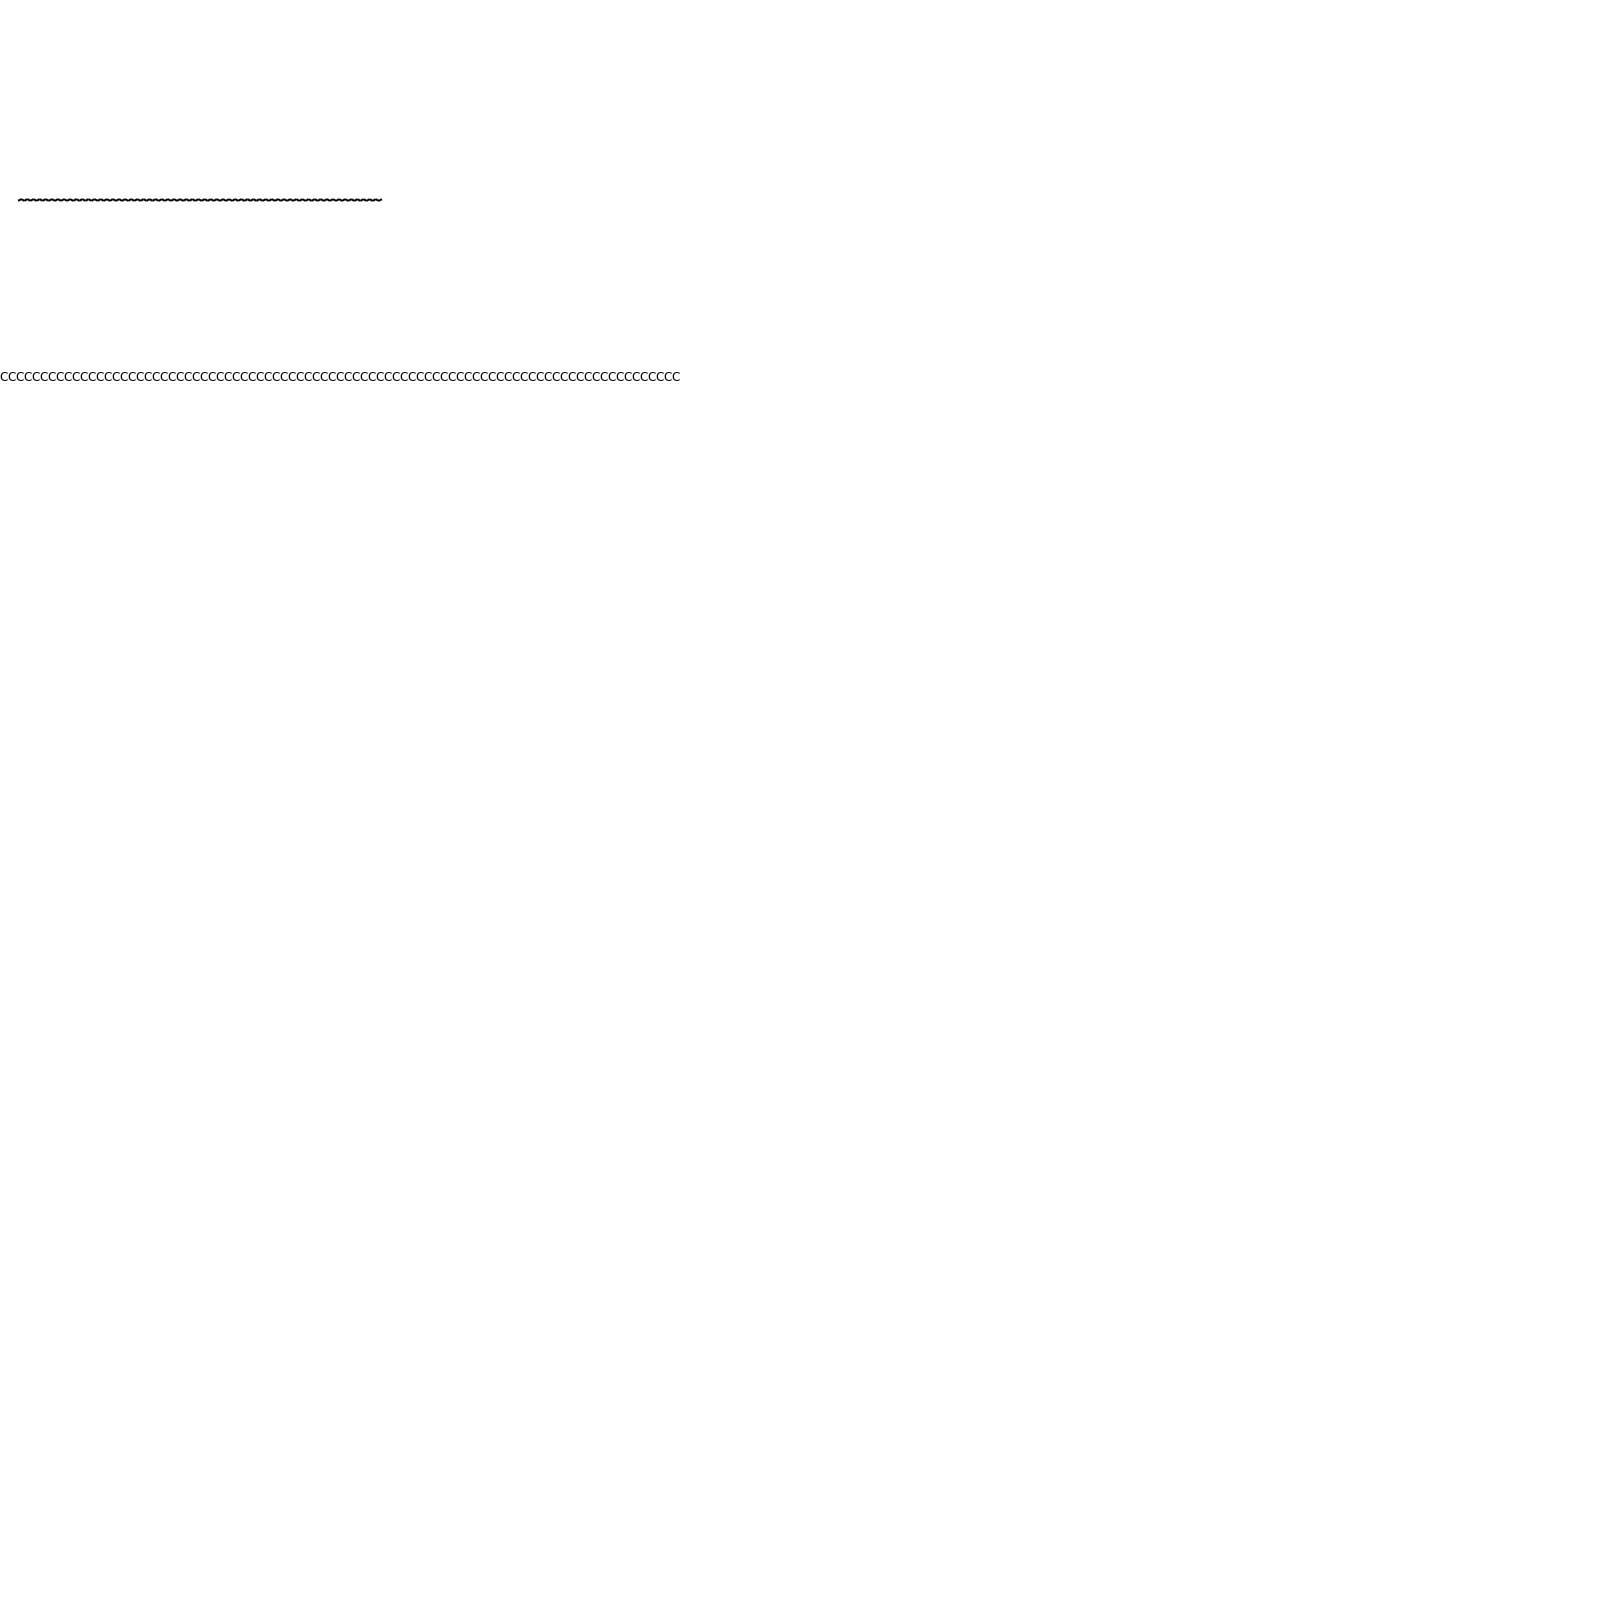

In [11]:
smiles_grid = prior_smiles_sample[:16]
mol_grid=[]
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)

### Validty, Uniqueness, Novelty

In [12]:
perc_valid, perc_chem_valid, perc_unique, perc_novel = \
eval_prior_samples(configs, prior_smiles_sample)

In [13]:
print('%s%% sampled SMILES from prior distribution are valid.' %str(round((perc_valid*100),1)))
print('%s%% valid SMILES from prior distribution are unique.' %str(round((perc_unique*100),1)))
print('%s%% valid SMILES from prior distribution are novel (not in training dataset)' %str(round((perc_novel*100),1)))

9.7% sampled SMILES from prior distribution are valid.
43.3% valid SMILES from prior distribution are unique.
100.0% valid SMILES from prior distribution are novel (not in training dataset)


### Chemical properties

* ZINC 250K: mean (std)
    * MolWeight: 331 (62)
    * QED: 0.73 (0.14)
    * SAS: 3.05 (0.83)
    * logP: 2.46 (1.43)
    
* FDA Drugs: mean (std)
    * MolWeight: 328 (125)
    * QED: 0.59 (0.2)
    * SAS: 3.14 (0.95)
    * logP: 2.27 (2.29)

In [14]:
#zinc_df = pd.read_csv('./data/250k_rndm_zinc_drugs_clean.smi.csv')
#fda_df = pd.read_csv('./data/all_drugs_only.smi.csv')

In [15]:
smi_prop_lst = []
for smi in prior_smiles_sample:
    try:
        mol = smiles_to_mol(smi)
        smi_len = len(smi)
        wt = mol_weight(smi)
        qed = mol_qed(smi)
        sas = mol_sas(smi)
        logP = mol_logp(smi)
        smi_prop_lst.append([smi, smi_len, wt, qed, sas, logP])
    except:
        pass
smi_prop_df = pd.DataFrame(smi_prop_lst, columns=['SMILES', 'LENGTH', 'MolWeight', 'QED', 'SAS', 'logP'])
print('Mean molecule weight: %f' %(smi_prop_df['MolWeight'].mean()))
print('STD molecule weight: %f' %(smi_prop_df['MolWeight'].std()))
print('Mean molecule QED: %f' %(smi_prop_df['QED'].mean()))
print('STD molecule QED: %f' %(smi_prop_df['QED'].std()))
print('Mean molecule SAS: %f' %(smi_prop_df['SAS'].mean()))
print('STD molecule SAS: %f' %(smi_prop_df['SAS'].std()))
print('Mean molecule logP: %f' %(smi_prop_df['logP'].mean()))
print('STD molecule logP: %f' %(smi_prop_df['logP'].std()))

Mean molecule weight: 2468.349561
STD molecule weight: 1200.016133
Mean molecule QED: 0.063382
STD molecule QED: 0.093262
Mean molecule SAS: 6.145034
STD molecule SAS: 1.953818
Mean molecule logP: 38.438618
STD molecule logP: 37.683902


## Sample decoded from posterior mean ~ q(z|x)

### Target SMILES

In [16]:
#smile_x = 'CC(C)Cc1ccc(C(C)C(=O)O)cc1' # Ibuprofen
smile_x = 'CC(C)[C@@H](CO)Nc1ccc(N)cc1Br'
#smile_x = 'C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O' #captopril
#smile_x = 'CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)O'

### Beam search ( width = 15) at the conditional mean point

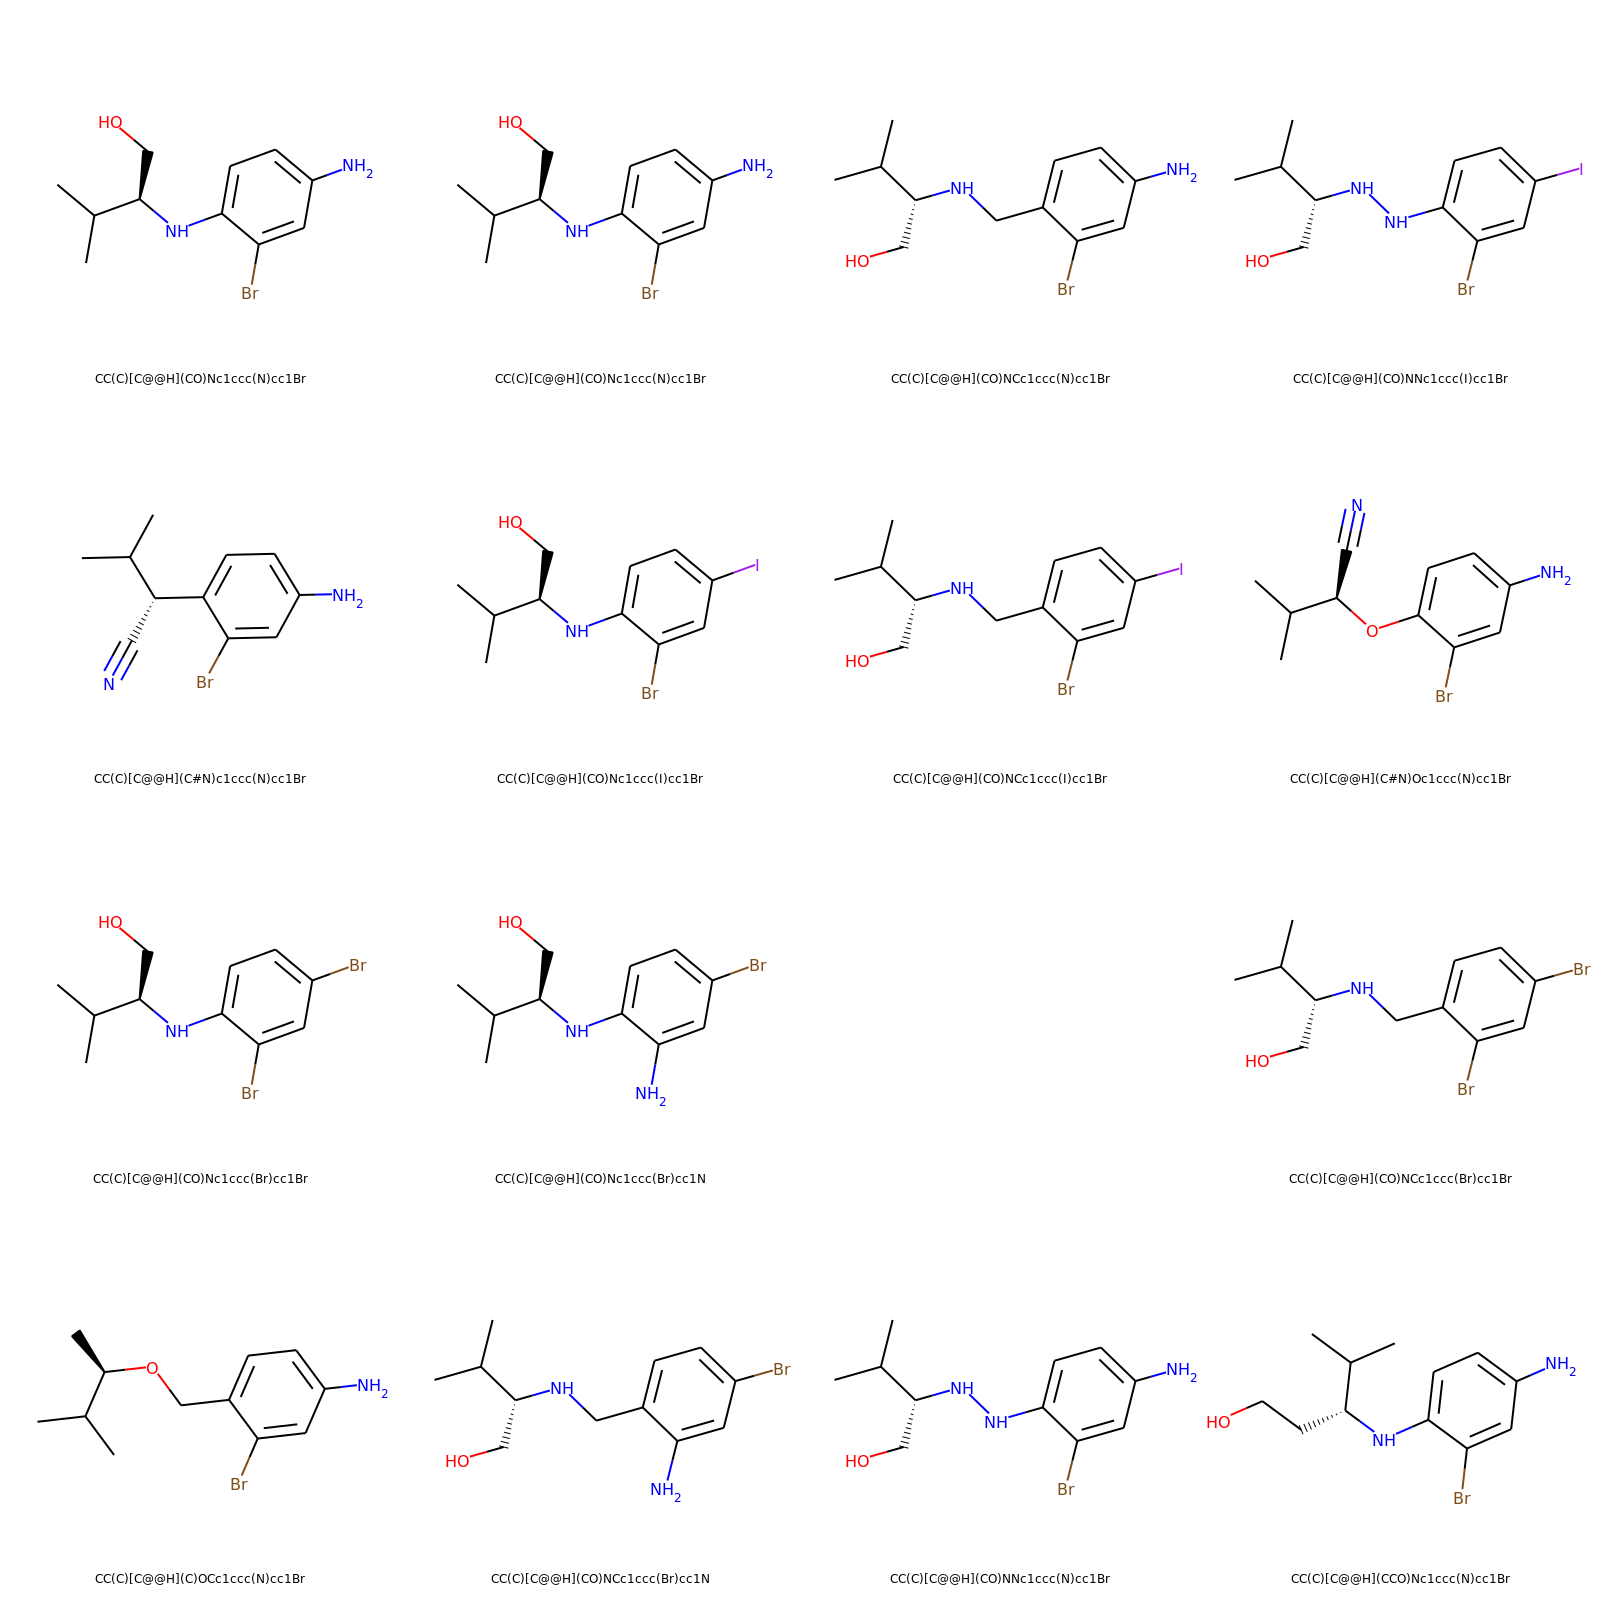

In [17]:
mean, _ = smiles2mean(configs, smile_x, model)
z, samples_idx, smiles_lst = latent2smiles(configs, model, mean, nsamples=15, sampling_mode='beam')

smiles_grid = [smile_x] + smiles_lst

mol_grid=[]
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

img=Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)
img

### Greedy search at latent points sampled from conditional posterior distribution

In [18]:
nsamples = 24

In [19]:
mean, logv = smiles2mean(configs, smile_x, model)
std = torch.exp(0.5 * logv)
if configs['manifold_type'] == 'Euclidean':
    z = to_cuda_var(torch.randn([nsamples, configs['latent_size']]))
    z = z * std + mean
    vt = None
    u = None
elif configs['manifold_type'] == 'Lorentz':
    vt, u, z = lorentz_sampling(mean.repeat(nsamples,1), logv.repeat(nsamples,1))

In [20]:
torch.exp(logv)

tensor([[0.0116, 0.0153, 0.0069, 0.0115, 0.0103, 0.0123, 0.0192, 0.0158, 0.0129,
         0.0056, 0.0098, 0.0094, 0.0114, 0.0114, 0.0107, 0.0023, 0.0114, 0.0107,
         0.0113, 0.0112, 0.0165, 0.0045, 0.0039, 0.0037, 0.0146, 0.0173, 0.0069,
         0.0113, 0.0047, 0.0079, 0.0090, 0.0089, 0.0074, 0.0107, 0.0147, 0.0090,
         0.0043, 0.0084, 0.0107, 0.0072]], device='cuda:0',
       grad_fn=<ExpBackward>)

In [21]:
samples_idx, z = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
smiles_x_samples = idx2smiles(configs, samples_idx)

In [22]:
smiles_x_samples_lst = [[smile_x, 0.0]]
for i in range(len(smiles_x_samples)):
    d2 = dist_z(configs['manifold_type'], mean.view(1,-1), z[i,:].view(1,-1))
    smiles_x_samples_lst.append([smiles_x_samples[i],d2.item()])
    
# sort by distance
smiles_x_samples_df = pd.DataFrame(smiles_x_samples_lst, columns=['SMILES','DISTANCE'])
smiles_x_samples_sorted = smiles_x_samples_df.sort_values(by=['DISTANCE']).SMILES.tolist()
smiles_x_distance_sorted = smiles_x_samples_df.sort_values(by=['DISTANCE']).DISTANCE.tolist()

# create legend
legend_lst = []
for l in range(len(smiles_x_samples_sorted)):
    legend = smiles_x_samples_sorted[l] + ' (' + str(round(smiles_x_distance_sorted[l],2)) + ')'
    legend_lst.append(legend)

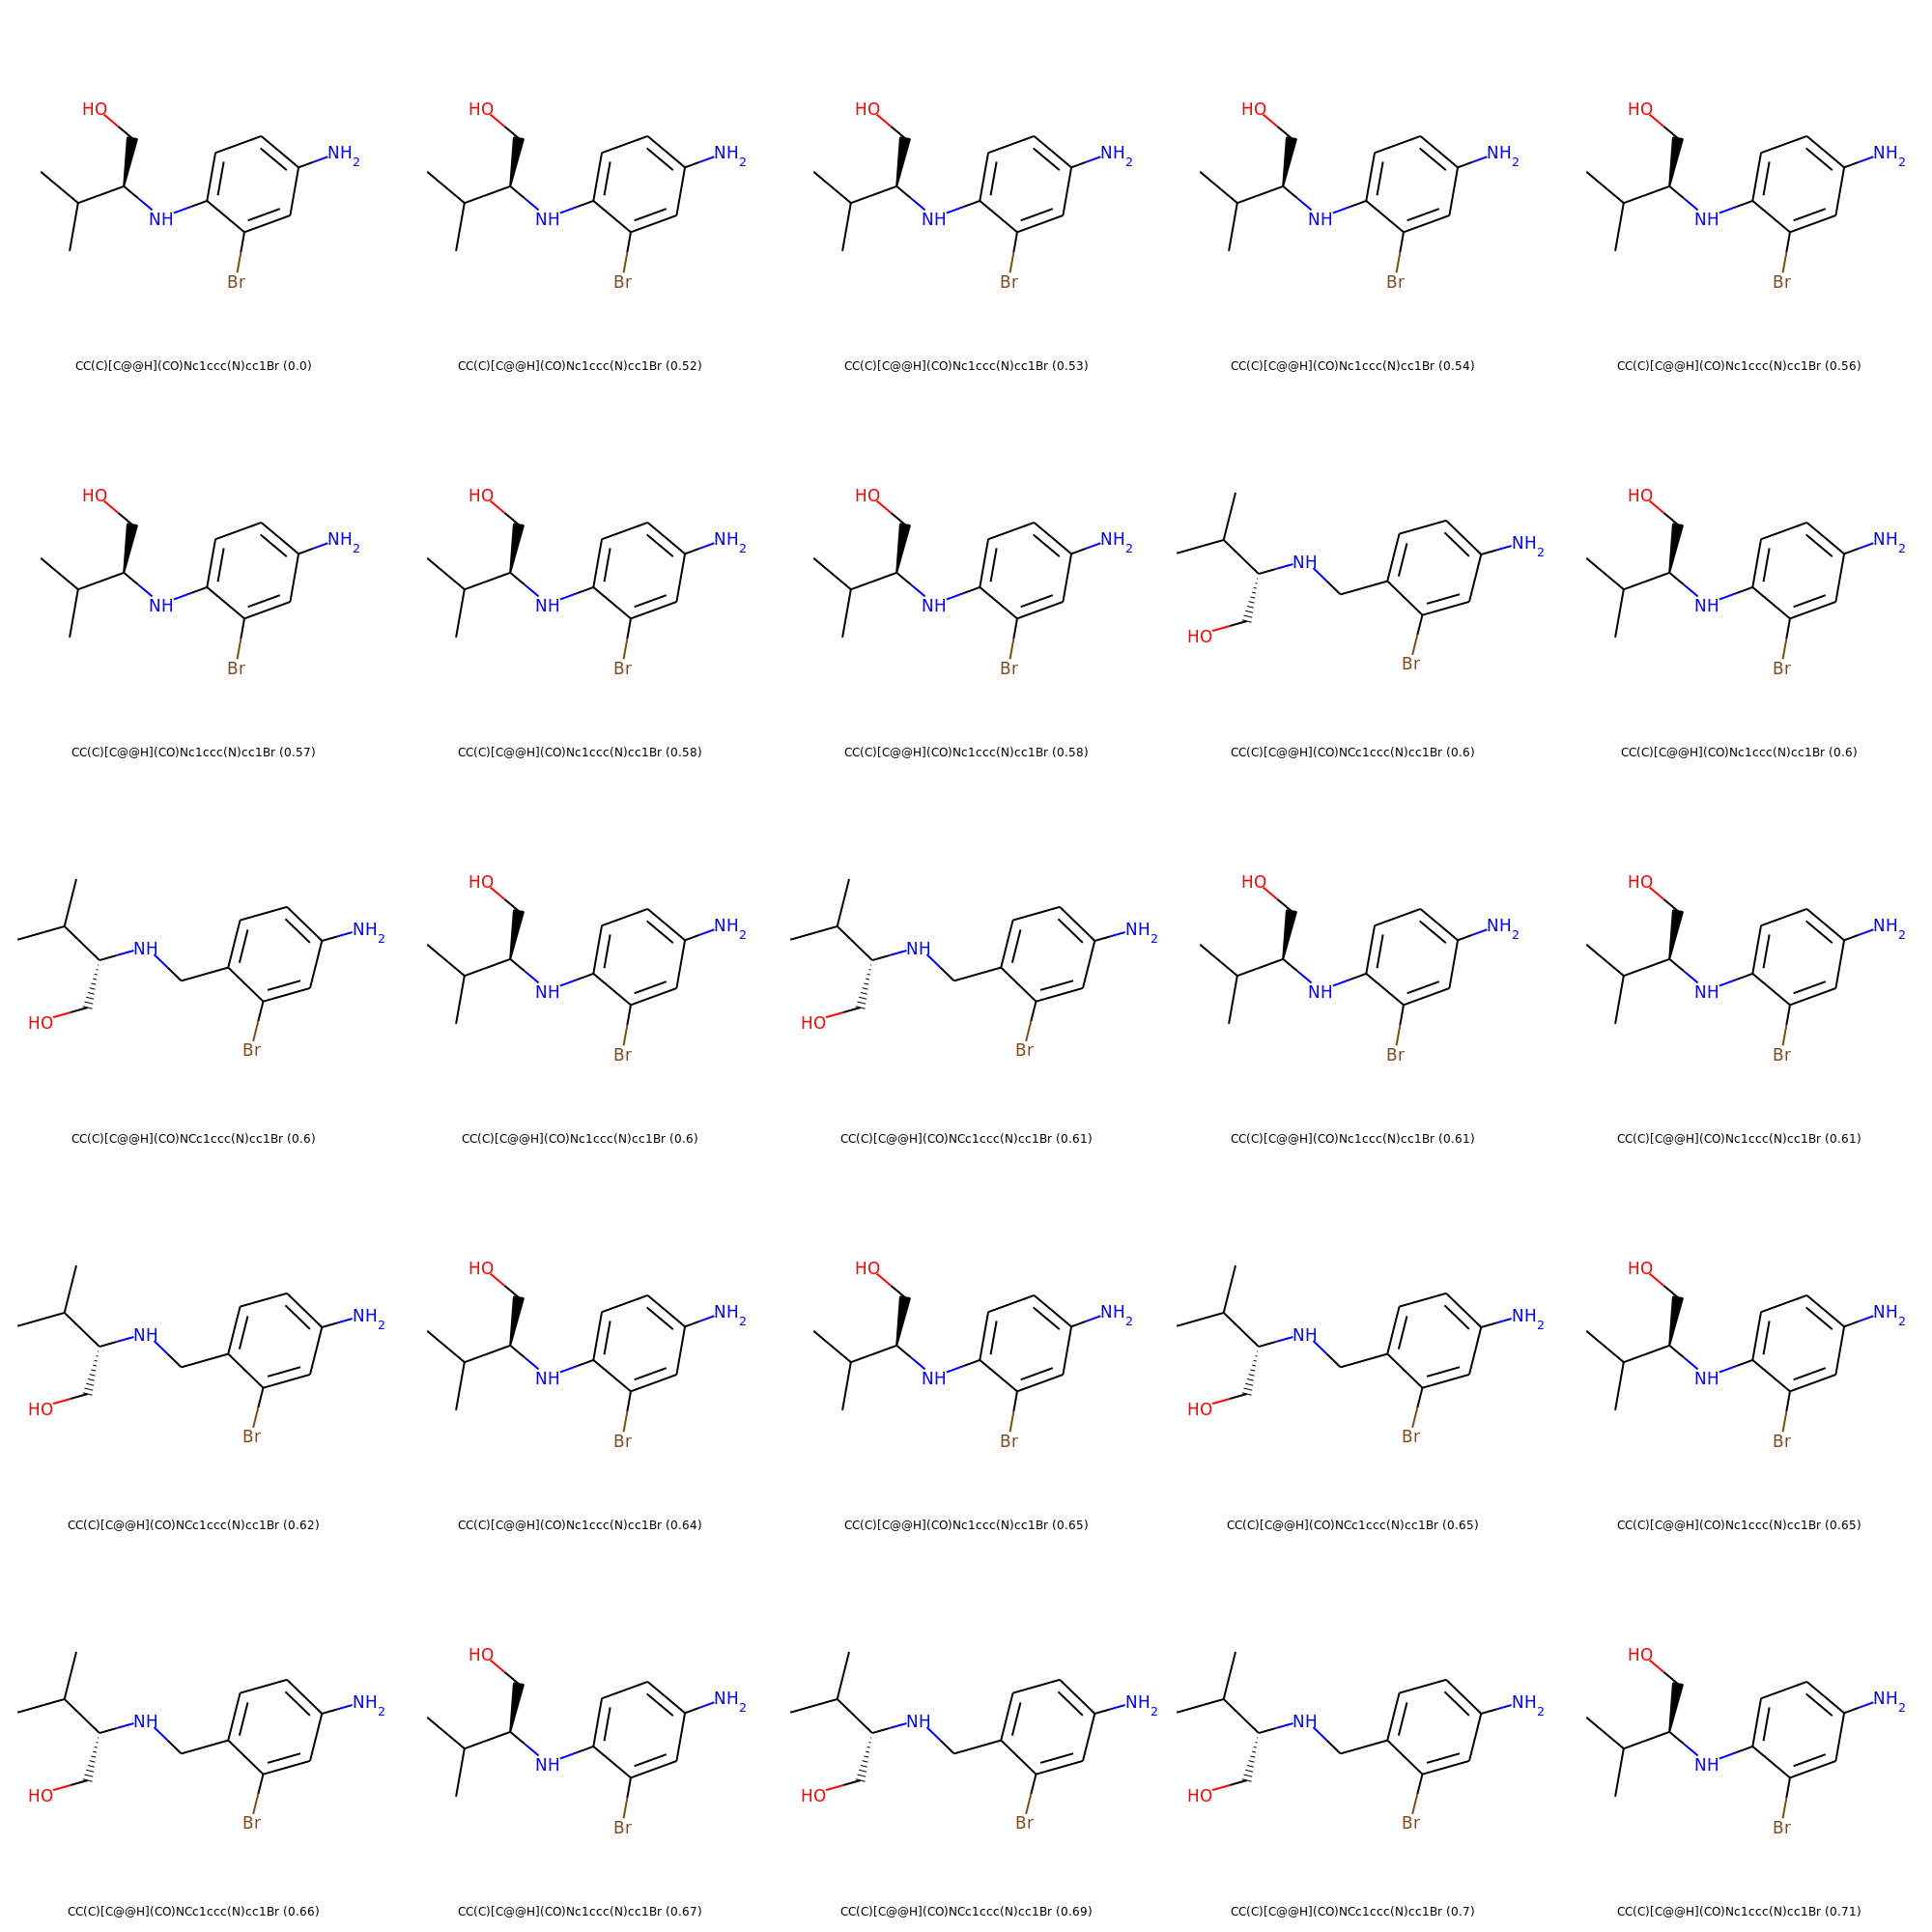

In [23]:
mol_grid=[]
smiles_grid = smiles_x_samples_sorted
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=5,subImgSize=(400,400), legends=legend_lst)

### Greedy search in the region centered at the conditional mean point

In [24]:
nsamples = 100
noise_norm = 10

In [25]:
mean, _ = smiles2mean(configs, smile_x, model)
if torch.cuda.is_available():
    mean = mean.cpu()
mean = mean.detach().numpy()
mean = np.tile(mean, (nsamples, 1))
z = perturb_z(mean, noise_norm, constant_norm=False)
z = torch.from_numpy(z)
z = to_cuda_var(z).float()
mean = torch.from_numpy(mean)
mean = to_cuda_var(mean).float()

In [26]:
samples_idx, z = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
smiles_x_neighors = idx2smiles(configs, samples_idx)

In [27]:
smiles_x_neighors_lst = [[smile_x, 0.0]]
for i in range(len(smiles_x_neighors)):
    d2 = dist_z(configs['manifold_type'], mean[i,:].view(1,-1), z[i,:].view(1,-1))
    smiles_x_neighors_lst.append([smiles_x_neighors[i],d2.item()])

# sort by distance
smiles_x_neighors_df = pd.DataFrame(smiles_x_neighors_lst, columns=['SMILES','DISTANCE'])
# delete distance = Nan
smiles_x_neighors_df = smiles_x_neighors_df.dropna()

smiles_x_neighors_sorted = smiles_x_neighors_df.sort_values(by=['DISTANCE']).SMILES.tolist()
smiles_x_distance_sorted = smiles_x_neighors_df.sort_values(by=['DISTANCE']).DISTANCE.tolist()



# create legend
legend_lst = []
for l in range(len(smiles_x_neighors_sorted)):
    legend = smiles_x_neighors_sorted[l] + ' (' + str(round(smiles_x_distance_sorted[l],2)) + ')'
    legend_lst.append(legend)

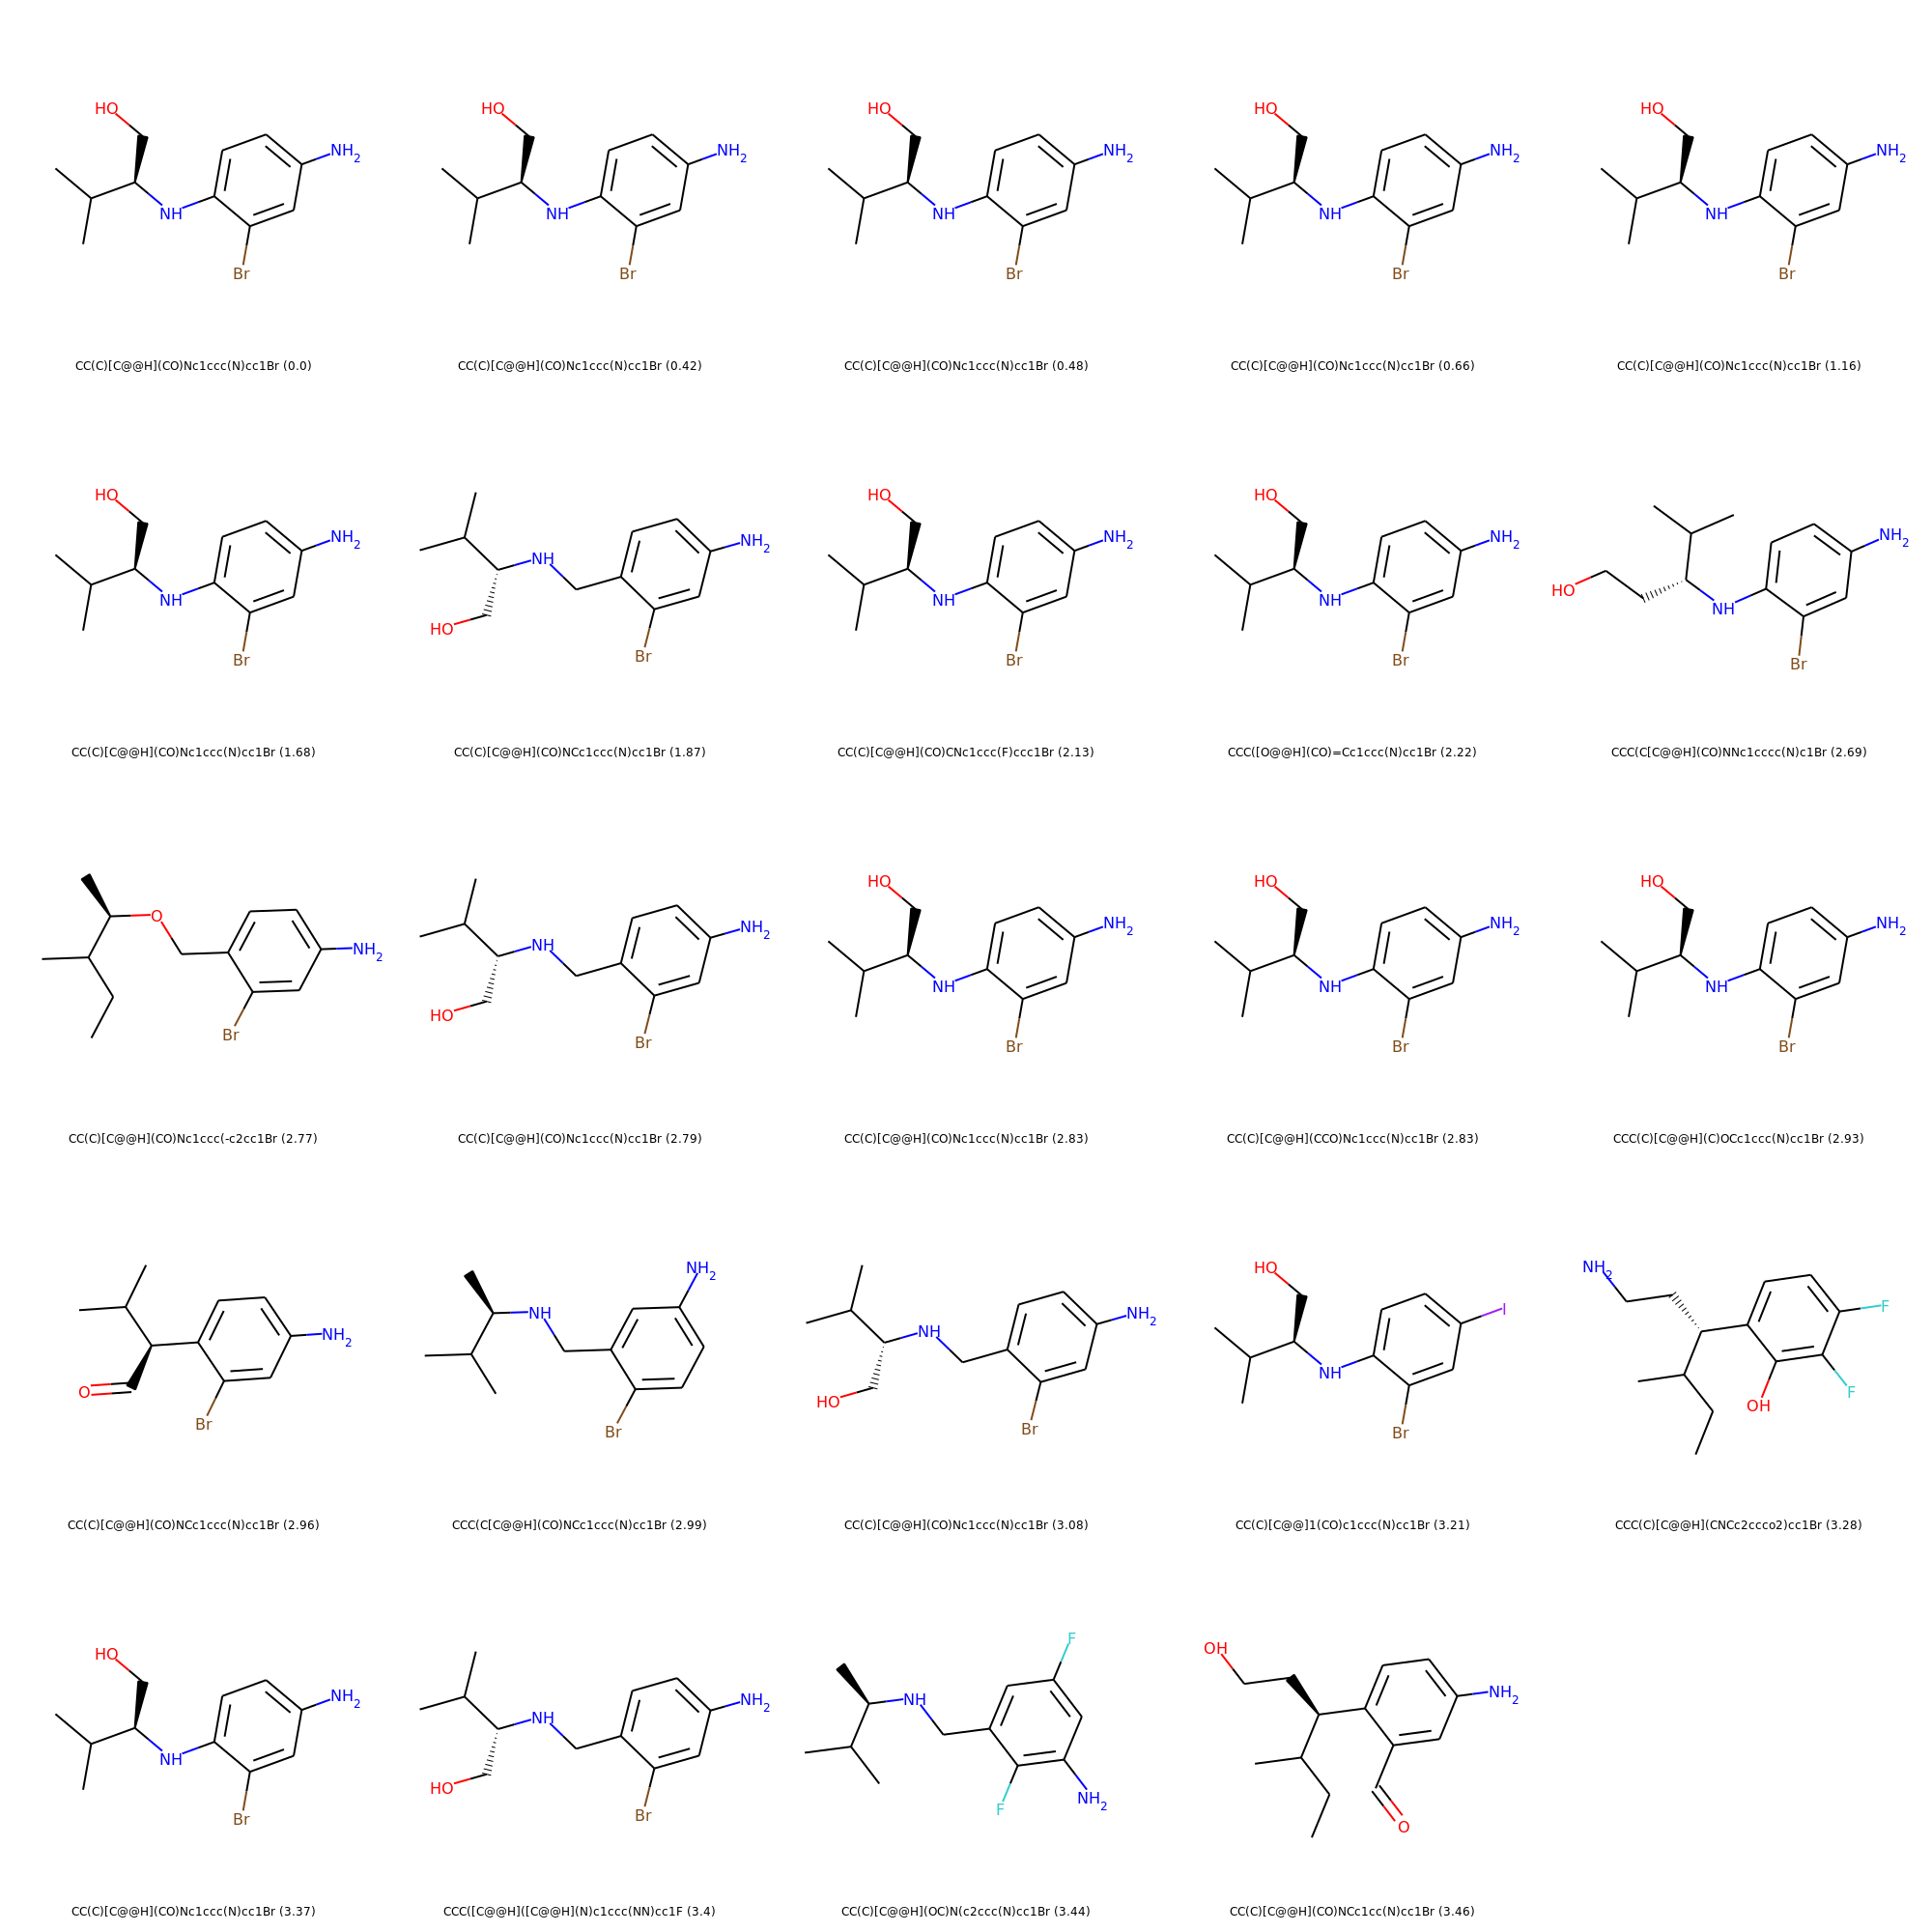

In [28]:
mol_grid=[]
smiles_grid = smiles_x_neighors_sorted
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

# remove invalid molecule from mol_grid
mol_grid = [m for m in mol_grid if m is not None]
Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=5,subImgSize=(400,400), legends=legend_lst)

### Conditional reconstruction accuracy

In [177]:
# use FDA drugs dataset
smiles_fda = create_smiles_lst('./data', 'all_drugs_only.smi')
# set beam width to 5
B = 5 

In [178]:
recon_cnt = 0
posterior_smiles_lst = []
for smi in smiles_fda:
    # skip smiles that has characters not in the ZINC char list
    try:
        mu, logv = smiles2mean(configs, smi, model)
        _, _, posterior_smiles_sample = latent2smiles(configs,model, z=mu, nsamples=B, sampling_mode='beam')
        posterior_smiles_lst = posterior_smiles_lst + posterior_smiles_sample
        if smi in posterior_smiles_sample:
            recon_cnt+=1
    except:
        pass

In [179]:
print('%s%% SMILES in FDA drugs are reconstructed accurately.' %str(round(100*recon_cnt/len(smiles_fda),2)))

27.15% SMILES in FDA drugs are reconstructed accurately.


### Conditional validty

In [180]:
perc_valid, perc_chem_valid, _, _ = \
eval_prior_samples(configs, posterior_smiles_lst)

In [181]:
print('Using beam search (width = 5), %s%% sampled SMILES from conditional posterior distribution are valid.' %str(round((perc_valid*100),1)))

Using beam search (width = 5), 34.0% sampled SMILES from conditional posterior distribution are valid.


### Distribution of pairwise distances between 1K test molecules
#### Euclidean VAE

In [34]:
exp_name = 'exp_a_7'
num_mdls = 12
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = smiles_test[:100]
dist_lst_euc, norm_euc = vae_pairwise_dist_hist(exp_name, num_mdls, input_smiles)

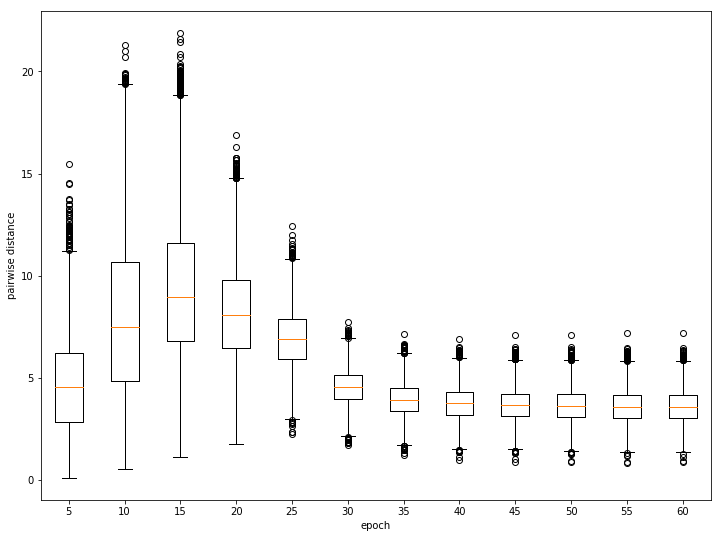

In [35]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(dist_lst_euc)

xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('pairwise distance')

fig.show()

### Distribution of embedding norms 1K test molecules
#### Euclidean VAE

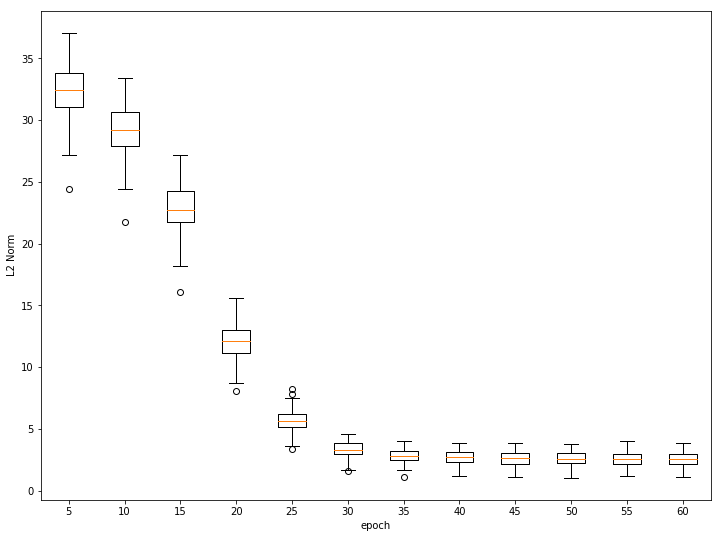

In [37]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(norm_euc)

xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('L2 Norm')

fig.show()

### Distribution of pairwise distances between 1K test molecules
#### Hyperbolic VAE

In [40]:
exp_name = 'exp_a_8'
num_mdls = 12
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = smiles_test[:100]
dist_lst_lor, norm_poincare = vae_pairwise_dist_hist(exp_name, num_mdls, input_smiles)

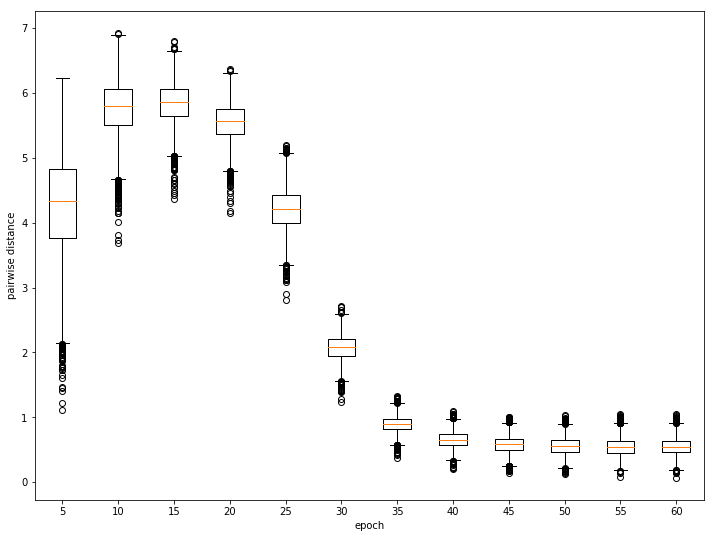

In [43]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(dist_lst_lor)
xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('pairwise distance')
fig.show()

### Distribution of embedding norms 1K test molecules
#### Euclidean VAE

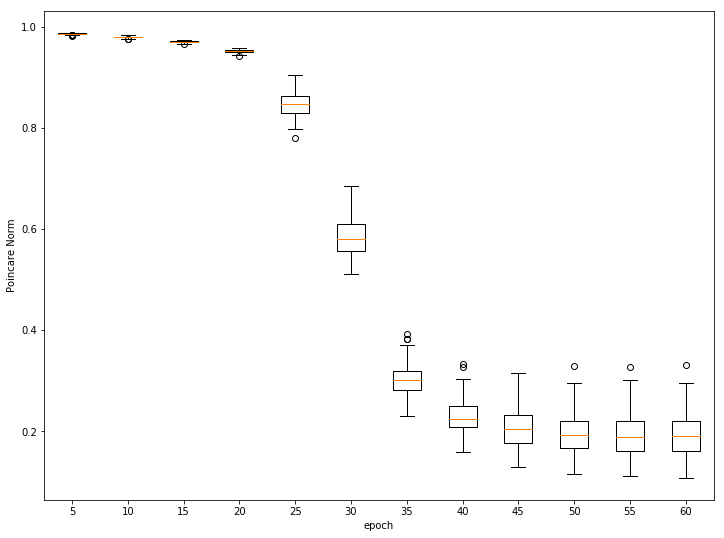

In [42]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(norm_poincare)
xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('Poincare Norm')
fig.show()